In [117]:
import scipy.stats as stats
import numpy as np
from seaborn import distplot
from matplotlib import pyplot as plt
import seaborn
from tqdm import tqdm

In [3]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in plt.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = plt.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    plt.rcParams.update(update_dict)
    plt.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = plt.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    plt.rcParams['legend.edgecolor'] = lec

In [4]:
inverse_plot_colorscheme()

Лекция посвящена ещё одному критерию для оценки среднего значения. Расмотрим следующую задачу

> 📈 **Задача**
>
> В нашей компании хотят перейти с одной СУБД на другую. Главным критерием для перехода является "затраченное время в сутках на загрузку новых данных". Если раньше для ежедневного обновления базы требовалось в среднем 10 часов, то хочется найти новую СУБД, в которой все это будет происходить быстрее, чем за 7 часов.
>
> Для этого было принято решение перенести все данные на новую тестируемую СУБД. В течение одной недели каждый день мы посчитаем время загрузки данных, и если в среднем на обновление будет уходить меньше 7 часов, то мы полностью перейдем на новую СУБД. Ваша задача придумать, как проверить гипотезу о том, что новая СУБД лучше старой.

Получилась выборка:

- `[6.9, 6.45, 6.32, 6.88, 6.19, 7.13, 6.76]` &mdash; время загрузки в новую БД по дням в часах.

Для начала переформулируем условие на языке математики: есть выборка
- $X_1, X_2, ..., X_7$ &mdash; время загрузки в часах новых данных в СУБД за каждый день эксперимента
- Еще будем считать, что $X$ из нормального распредения.

In [5]:
X = np.array([6.9, 6.45, 6.32, 6.88, 6.09, 7.13, 6.76])
X.mean()

np.float64(6.647142857142858)

Наша гипотеза звучит так:

$H_0$: $E \overline{X} \geq 7\ vs.\ H_1: E \overline{X} < 7$

Или то же самое, если считать что $X_1, X_2, ..., X_7 \sim \mathcal{N}(\theta, \sigma ^ 2)$, то гипотеза выглядит так

$H_0$: $\theta \geq 7\ vs.\ H_1: \theta < 7$

Вообще, на такой случай есть лемма Фишера, которая говорит следующее

>**Лемма Фишера**
>
>Пусть $X_1, X_2, ..., X_n \sim \mathcal{N}(\theta, \sigma ^ 2)$   
>
>$\overline X = \frac{X_1 + ... + X_n}{n}, S_n^2 = \frac{(X_1 - \overline X)^2 + ... + (X_n - \overline X)^2}{n} $   
>
>Тогда:   
>
>1. $\sqrt{n} \frac{\overline X - \theta}{\sigma} \sim \mathcal{N}(0, 1)$    
>
>2. $\overline X и S_n^2 независимы$    
>
>3. $\frac{n S_n^2}{\sigma ^ 2} \sim \chi _{n - 1}^2$    
>
>4. $\frac{\sqrt{n - 1}(\overline X - \theta)}{S_n} \sim t_{n - 1}$, где $t_{n - 1}$ - случайная величина с распределением Стьюдента с n степенями свободы, $t_n = \frac{\sqrt{n} \xi}{\chi _n}$, где $\xi$ - стандартная нормальная

Один момент: так определённое $S_n ^ 2$ не является несмещённой оценкой дисперсии, поэтому принять считать другую величину - $\sigma _n^2 = \frac{(X_1 - \overline X)^2 + ... + (X_n - \overline X)^2}{n - 1}$

Для неё лемма будет выглядеть следующим образом

>**Лемма Фишера**
>
>Пусть $X_1, X_2, ..., X_n \sim \mathcal{N}(\theta, \sigma ^ 2)$   
>
>$\overline X = \frac{X_1 + ... + X_n}{n}, \sigma _n^2 = \frac{(X_1 - \overline X)^2 + ... + (X_n - \overline X)^2}{n - 1}$   
>
>Тогда:   
>
>1. $\sqrt{n} \frac{\overline X - \theta}{\sigma} \sim \mathcal{N}(0, 1)$    
>
>2. $\overline X и \sigma _n^2 независимы$    
>
>3. $\frac{(n - 1)  \sigma _n^2}{\sigma ^ 2} \sim \chi _{n - 1}^2$    
>
>4. $\frac{\sqrt{n}(\overline X - \theta)}{ \sqrt{\sigma _n^2}} \sim t_{n - 1}$

Вычисляется на python она следующим образом

In [6]:
X.var(ddof=1)

np.float64(0.1367238095238095)

Вообще, при больших n распределение Стьюдента очень похоже на стандартное нормальное, проиллюстрируем это

In [52]:
def get_stud_norm(df_num):
    x = np.linspace(-5, 5, 1_000_000)
    norm = stats.norm(loc=0, scale=1).pdf(x)
    stud = stats.t(df=df_num).pdf(x)

    fig, ax = plt.subplots()

    ax.set(xlim=(-5, 5))

    ax.plot(x, norm, label='norm')
    ax.plot(x, stud, label='stud')
    ax.legend()

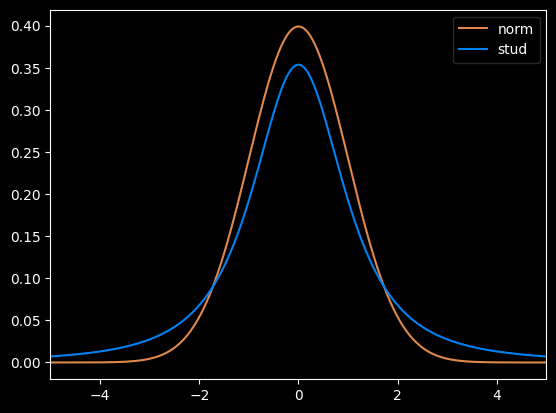

In [54]:
get_stud_norm(2)

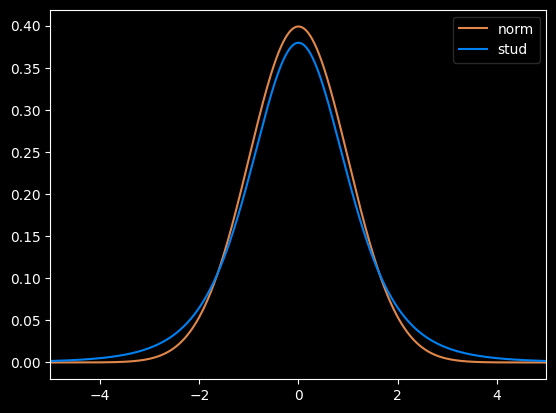

In [55]:
get_stud_norm(5)

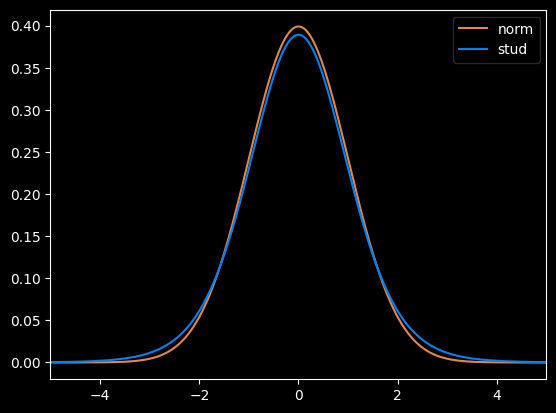

In [56]:
get_stud_norm(10)

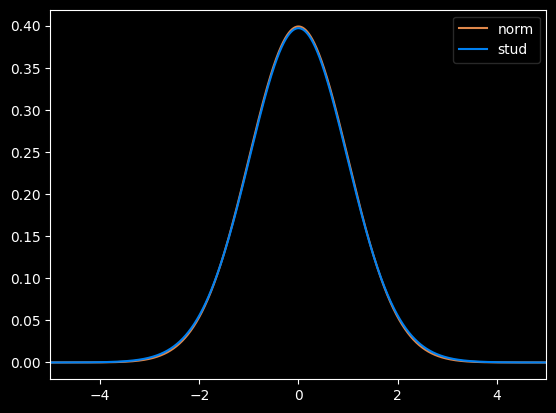

In [57]:
get_stud_norm(50)

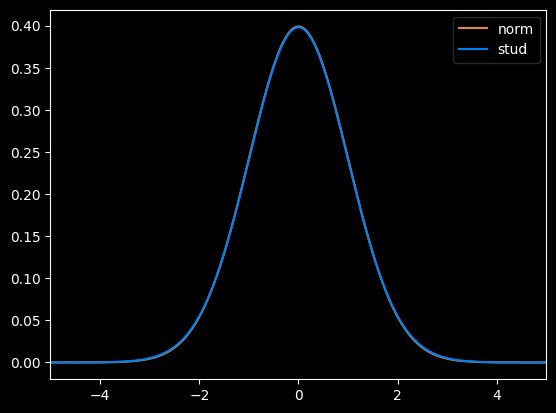

In [58]:
get_stud_norm(100)

Вооружившись леммой, можем решить задачу


### T-test, критерий

$H_0: \mu =\mu_0, X \sim \mathcal{N}\ vs.\ H_1: \mu \neq \mu_0$ или $X$ не из нормального распределения 
- Статистика - $T(X) = \frac{\sqrt{n}(\overline X - \theta)}{ \sqrt{\sigma _n^2}}$   
- Её распределение - $t_{n-1}$
- Односторонний критерий: $\left\{T(X) \geq t_{n-1, 1 - \alpha} \right\}$
    - p-value = $1 - \tau_{n-1}(z)$, где z &mdash; реализация статистики $T(X)$, $\tau_{n-1}(z)$ &mdash; функция распределения $t_{n - 1}$
- Двусторонний критерий: $\left\{T(X) \geq t_{n-1, 1 - \frac{\alpha}{2}} \right\} \bigcup \left\{T(X) \leq -t_{n-1, 1 - \frac{\alpha}{2}} \right\} $
    - p-value = $2\cdot \min \left[{\tau_{n-1}(z), 1 - \tau_{n-1}(z)} \right]$, где z &mdash; реализация статистики $T(X)$

В Python есть функция T-теста

In [61]:
stats.ttest_1samp(X, popmean=7, alternative='less')

TtestResult(statistic=np.float64(-2.524793468045073), pvalue=np.float64(0.02249742917295711), df=np.int64(6))

Мы видим, что на уровне значимости 2.5% критерий отвергся, а значит переход на новую СУБД удовлетворяет условиям: загрузка быстрее 7 часов!

Нарисуем соответствующие графики

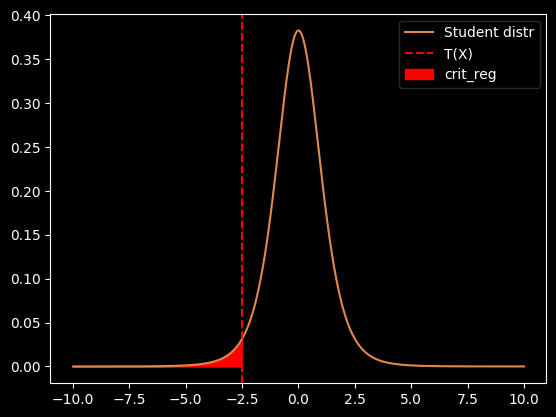

In [85]:
T_X = np.sqrt(7) * (X.mean() - 7) / np.sqrt(X.var(ddof=1))
t = stats.t(df=6)

x = np.linspace(-10, 10, 1_000)
y = t.pdf(x)

fig, ax = plt.subplots()

ax.plot(x, y, label='Student distr')
ax.axvline(T_X, ls='--', color='red', label='T(X)')
ax.fill_between(x, y, where=(x <= T_X), color='red', label='crit_reg')

ax.legend()

In [86]:
print(t.cdf(T_X))

0.02249742917295711


Нетрудно вывести формулу для доверительного интервала   
$CI_{\mu} = \left(\overline X \pm \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} \right)$. 

In [107]:
mean = X.mean()
sem = np.sqrt(X.var(ddof=1)) / np.sqrt(len(X)) #sem - standart error of the mean, sem = sqrt(S^2)/sqrt(n)

left, right = stats.t.interval(confidence=0.95, loc=mean, scale=sem, df=len(X) - 1)
print(round(left, 2), round(right, 2))

6.31 6.99


На самом деле, Т-тест работает хорошо даже на выборке, сэмплированной не из нормального распределения, это связано с тем, что приведённая выше оценка дисперсии является состоятельной, поэтому при достаточно большом объёме выборки можно смело использовать T-test, причём, как я упоминал ранее, распределение Стьюдента при большом числе степеней свободны почти неотличимо от нормального, поэтому можно просто считать, что T(X) имеет стандартное нормальное распределение

Проиллюстрируем это на графике для экспоненциального и биномиального распределений

100%|██████████| 10000/10000 [00:03<00:00, 2728.88it/s]


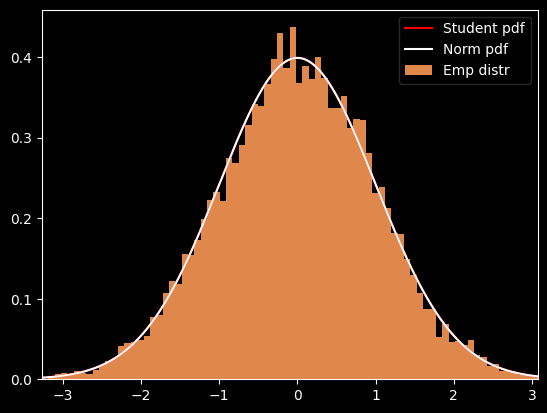

In [149]:
n = 10_000
sample_size = 10_000

sample_distr = stats.expon(scale=1/2)

T = np.empty(n)

for i in tqdm(range(n)):
    x = sample_distr.rvs(sample_size)
    T_X = np.sqrt(sample_size) * (x.mean() - sample_distr.mean()) / x.std(ddof=1)
    T[i] = T_X

fig, ax = plt.subplots()

left, right = np.quantile(T, 0.001), np.quantile(T, 0.999)
ax.set(xlim=(left, right))

x = np.linspace(left, right, 10_000)

ax.plot(x, stats.t(df=sample_size - 1).pdf(x), color='red', label='Student pdf')
ax.plot(x, stats.norm(loc=0, scale=1).pdf(x), color='white', label='Norm pdf')
ax.hist(T, bins=100, density=True, label='Emp distr')

ax.legend()

100%|██████████| 10000/10000 [00:10<00:00, 969.47it/s]


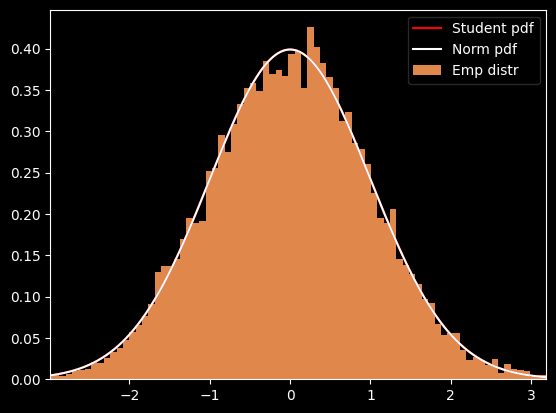

In [148]:
n = 10_000
sample_size = 10_000

sample_distr = stats.binom(n=30, p=0.7)

T = np.empty(n)

for i in tqdm(range(n)):
    x = sample_distr.rvs(sample_size)
    T_X = np.sqrt(sample_size) * (x.mean() - sample_distr.mean()) / x.std(ddof=1)
    T[i] = T_X

fig, ax = plt.subplots()

left, right = np.quantile(T, 0.001), np.quantile(T, 0.999)
ax.set(xlim=(left, right))

x = np.linspace(left, right, 10_000)

ax.plot(x, stats.t(df=sample_size - 1).pdf(x), color='red', label='Student pdf')
ax.plot(x, stats.norm(loc=0, scale=1).pdf(x), color='white', label='Norm pdf')
ax.hist(T, bins=100, density=True, label='Emp distr')

ax.legend()
    

100%|██████████| 10000/10000 [00:01<00:00, 5007.70it/s]


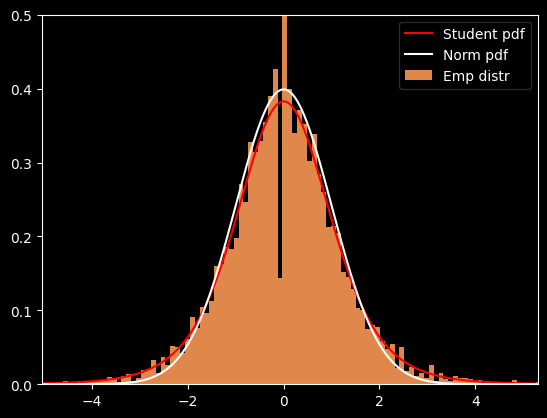

In [176]:
n = 10_000
sample_size = 7

sample_distr = stats.binom(n=30, p=0.6)

T = np.empty(n)

for i in tqdm(range(n)):
    x = sample_distr.rvs(sample_size)
    T_X = np.sqrt(sample_size) * (x.mean() - sample_distr.mean()) / x.std(ddof=1)
    T[i] = T_X

fig, ax = plt.subplots()

left, right = np.quantile(T, 0.001), np.quantile(T, 0.999)
ax.set(xlim=(left, right), ylim=(0, 0.5))

x = np.linspace(left, right, 10_000)

ax.plot(x, stats.t(df=sample_size - 1).pdf(x), color='red', label='Student pdf')
ax.plot(x, stats.norm(loc=0, scale=1).pdf(x), color='white', label='Norm pdf')
ax.hist(T, bins=200, density=True, label='Emp distr')

ax.legend()

100%|██████████| 10000/10000 [00:01<00:00, 6475.52it/s]


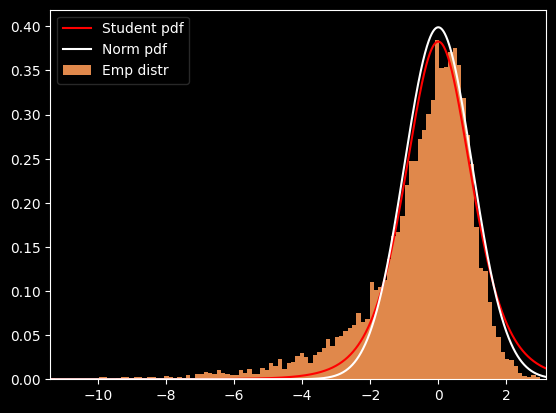

In [182]:
n = 10_000
sample_size = 7

sample_distr = stats.expon(scale=1 / 2)

T = np.empty(n)

for i in tqdm(range(n)):
    x = sample_distr.rvs(sample_size)
    T_X = np.sqrt(sample_size) * (x.mean() - sample_distr.mean()) / x.std(ddof=1)
    T[i] = T_X

fig, ax = plt.subplots()

left, right = np.quantile(T, 0.001), np.quantile(T, 0.999)
ax.set(xlim=(left, right))

x = np.linspace(left, right, 10_000)

ax.plot(x, stats.t(df=sample_size - 1).pdf(x), color='red', label='Student pdf')
ax.plot(x, stats.norm(loc=0, scale=1).pdf(x), color='white', label='Norm pdf')
ax.hist(T, bins=200, density=True, label='Emp distr')

ax.legend()